## Problem Satement

SafeBabies is a large company who is producing car seats for babies and toddlers. They sell their products all over the US and abroad. The management team has hired you as a Business Analytics consultant to help them maximizing their profit.

The primary tasks are to determine:
1. The optimal price for selling the car seats at those stores where the shelve location is good (i.e. the product is highly visible)?
2. The optimal price for selling the car seats at those stores where the shelve location is bad (i.e. the product is highly visible)?
3. Plot the optimal price for selling the car seats at those stores where the shelve location is good and those where the shelve location is bad when varying the production costs from \$40 to \$85.

You have been told that the __cost of producing__ each car seat is \$55.0.

In [28]:
library(ISLR)
library(magrittr)
library(dplyr)
library(ggplot2)

# Change size of graphs globally
options(repr.plot.width = 6, repr.plot.height = 5)

Our dataset named `safebabies_df` will consist of 3 variables for the 400 stores of SafeBabies.

In [5]:
safebabies_df <- Carseats %>% select(Sales, Price, ShelveLoc)
head(safebabies_df)

Sales,Price,ShelveLoc
9.50,120,Bad
11.22,83,Good
10.06,80,Medium
7.40,97,Medium
4.15,128,Bad
10.81,72,Bad


Using the `summary` function we will produce the 5 number summary of our 3 variables.

In [6]:
summary(safebabies_df)

     Sales            Price        ShelveLoc  
 Min.   : 0.000   Min.   : 24.0   Bad   : 96  
 1st Qu.: 5.390   1st Qu.:100.0   Good  : 85  
 Median : 7.490   Median :117.0   Medium:219  
 Mean   : 7.496   Mean   :115.8               
 3rd Qu.: 9.320   3rd Qu.:131.0               
 Max.   :16.270   Max.   :191.0               

where
* __Sales__ is unit sales (in thousands) at each store location
* __Price__ is the price that company charges for car seats at each site
* __ShelveLoc__ is a factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each store.

Because `Sales` is in thousands we must multiply `Sales` variable by a 1000 before proceeding. 

In [7]:
safebabies_df <- safebabies_df %>% mutate(Sales = Sales * 1000)
summary(safebabies_df)

     Sales           Price        ShelveLoc  
 Min.   :    0   Min.   : 24.0   Bad   : 96  
 1st Qu.: 5390   1st Qu.:100.0   Good  : 85  
 Median : 7490   Median :117.0   Medium:219  
 Mean   : 7496   Mean   :115.8               
 3rd Qu.: 9320   3rd Qu.:131.0               
 Max.   :16270   Max.   :191.0               

The first step to accomplishing tasks 1 and 2 is to split the dataset `safebabies_df` into two seperate datasets. The first one will contain rows (stores) where `ShelveLoc` is __Good__ and we will name it `good_df` while the second one will contain rows (stores) where `ShelveLoc` is __Bad__ and we will name it `bad_df`.

In [8]:
good_df <- safebabies_df %>% filter(ShelveLoc == "Good")
bad_df <- safebabies_df %>% filter(ShelveLoc == "Bad")

## Finding The Optimal Price

### The Intuition

Optimal price can be defined as the price that offers the best profit and is greater than the cost of production. Given the definition of optimal price, our goal is to find a price such that the total profit is maximized accross all stores.

Total profit can be defined using the following equation:

$P_t = P_u * S_u$

where

* $P_t$ is the total profit at each store
* $P_u$ is the profit per unit
* $S_u$ is the `Sales` variable (unit sales in thousands)

The goal at this stage is to express total profit per store in terms of price and to do that we must also express $P_u$ and $S_u$ in terms of price. 

$P_u$ can be expressed using the following equation:

$P_u = Price - Cost$

The equation above essentially says that the profit per unit is simple expressed as the price per unit minus the cost of producing the unit.

$S_u$ was defined as the unit sales in thousands meaning the number of units each store sold. If we were to express $S_u$ in terms of price then we would have to take inspiration from OLS, by doing that we can express $S_u$ using the following equation:

$S_u = \theta_0 + \theta_1Price$

where 
* $\theta_0$ is the y intercept
* $\theta_1$ is the coefficient for price

By using a linear regression equation (OLS) to define $S_u$ we have succeded in expressing $S_u$ (`Sales`) in terms of price. The linear regression model can easily determine the best $\theta_0$ and $\theta_1$ for predicting $S_u$

We can now redefine $P_t$ as: 

$P_t = (Price - Cost)(\theta_0 + \theta_1Price)$

and then further expand it to: 

$P_t = \theta_1Price^2 + (\theta_0 - \theta_1Cost)Price - \theta_0Cost$

The equation for $P_t$ gives of a quadratic equation which represents the price elasticity for profit which means that it will tell us how profit accross all stores changes as we change the price.

In order to find the optimal price we find the first derivative of the quadratic equation and set the derivative to zero. We will redine our equation as follows:

$P_t(p) = \theta_1p^2 + (\theta_0 - \theta_1c)p - \theta_0c$

where 
* $P_t(p)$ is a function
* $p$ is the price per unit 
* $c$ is the cost of producing the unit which is a known constant
* $\theta_0$ and $\theta_1$ are constants that needs to be found

Taking the first derivative of the function $P_t(p)$ we obtain

$P_t'(p) = 2\theta_1p + \theta_0 - \theta_1c$

then setting the derivative to 0 and then making $p$ the subject of formula we obtain:

$0 = 2\theta_1p + \theta_0 - \theta_1c$

$ - \theta_0 + \theta_1c = 2\theta_1p$

$p =  \frac{- \theta_0 + \theta_1c}{2\theta_1}$

The formula for $p$ becomes the formula for finding the optimal price.

Let's define a function in are called `calc_optimal_price` that we compute $p$ given $c, \theta_0, and \theta_1$

In [16]:
calc_optimal_price <- function(prod_cost, theta_0, theta_1) {
    return(((-1 * theta_0) + (theta_1 * prod_cost)) / (2 * theta_1))
}

### Optimal Price for Good Shelf Locations

The first thing to do is to construct our linear regression model to obtain the coefficients $\theta_0$ and $\theta_1$ which we will need for the `calc_optimal_price` function

In [10]:
good_coeffs <- lm(Sales ~ Price, data = good_df) %>% use_series("coefficients")
good_coeffs

(Intercept)       Price 
17968.86360   -65.78477

In [11]:
gtheta_0 <- good_coeffs[[1]]
gtheta_1 <- good_coeffs[[2]]

calc_optimal_price(55, gtheta_0, gtheta_1)

[1] 164.0731

The optimal price that offers the best total profit for `ShelveLoc` categorized as __Good__ is $164.073 but rounded up we obtain an optimal price of __\$164__.

### Optimal Price for Bad Shelf Locations

Just like in the case of good shelf locations we construct our linear regression model to obtain the coefficients $\theta_0$ and $\theta_1$.

In [12]:
bad_coeffs <- lm(Sales ~ Price, data = bad_df) %>% use_series("coefficients")
bad_coeffs

(Intercept)       Price 
11832.98389   -55.22028

We will then create a column call `Profit_t` which is the total profit for each store where the `ShelveLoc` is __Bad__.

In [13]:
btheta_0 <- bad_coeffs[[1]]
btheta_1 <- bad_coeffs[[2]]

calc_optimal_price(55, btheta_0, btheta_1)

[1] 134.6435

The optimal price that offers the best total profit for `ShelveLoc` categorized as __Bad__ is $134.643 but rounded up we obtain an optimal price of __\$135__.

## Optimal Price as Production Cost Changes

In [17]:
prod_costs <- seq(40, 85, by = 5)

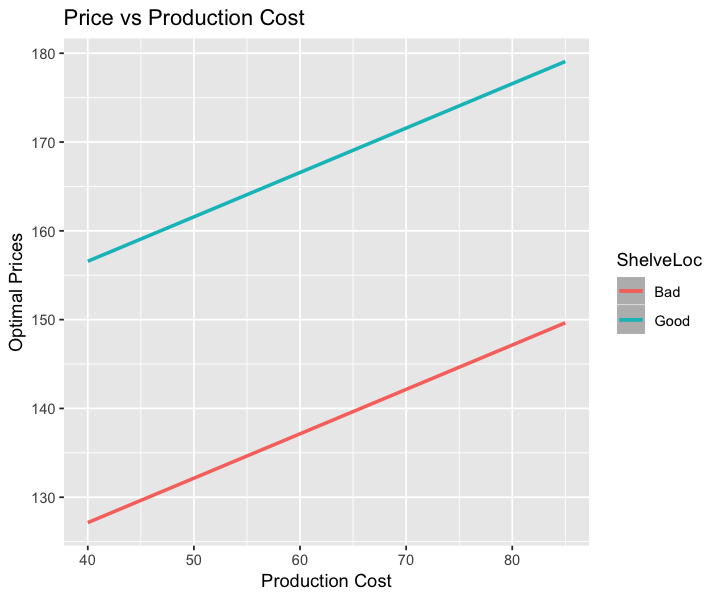

In [27]:
good_optimal_prices <- c()
bad_optimal_prices <- c()

local({
    for (prod_cost in prod_costs) {
        # Good Shelf Locations
        optimal_price_good <- calc_optimal_price(prod_cost, gtheta_0, gtheta_1)
        good_optimal_prices <- c(good_optimal_prices, optimal_price_good)
        
        # Bad Shelf Locations
        optimal_price_bad <- calc_optimal_price(prod_cost, btheta_0, btheta_1)
        bad_optimal_prices <- c(bad_optimal_prices, optimal_price_bad)
    }

    optimal_prices_df <- data.frame(
        Optimal_Good_Prices = good_optimal_prices,
        Optimal_Bad_Prices = bad_optimal_prices
    )

    head(optimal_prices_df)

    ggplot(optimal_prices_df) +
        geom_smooth(aes(x = prod_costs, y = Optimal_Good_Prices, color = "Good"), method = "loess") +
        geom_smooth(aes(x = prod_costs, y = Optimal_Bad_Prices, color = "Bad"), method = "loess") +
        labs(
            color = "ShelveLoc",
            x = "Production Cost",
            y = "Optimal Prices",
            title = "Price vs Production Cost"
        )
})

The plot titled __Price vs Production Cost___ shows that as the production cost increases so does the price of both good and bad shelf locations therefore showing a linear dependence between cost and price.

Although the plot shows that as the production cost increases so does the price for both good and bad shelf locations, the optimal price starts at a higher point on the y axis for good shelf locations than bad shelf locations.